# Product Category Classification

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
import itertools

import sys
sys.path.append('../utilities')
from data_utils import *
from ml_utils import *

### Prepare data

We will use categories that have at lease 100 products with ingredient info. As one product may belong to more than one category, we will do a multi-label classification.

In [2]:
# read cleaned data
skin_care_df = pd.read_csv('../data_cleaning/skin_care_cleaned.csv')
body_care_df = pd.read_csv('../data_cleaning/body_care_cleaned.csv')
makeup_df = pd.read_csv('../data_cleaning/makeup_cleaned.csv')

# merge skin-care, body-care and makeup table
df = pd.concat([skin_care_df,body_care_df,makeup_df], sort=False).reset_index(drop=True)

# drop products without ingredient info
df = df.loc[~df['ingredient'].isnull()]

# pick large categories, with more than 100 products
large_categories = ['Nighttime Moisturizer', 'Cleansers', 'Serum','Exfoliants', 
                    'Eye Cream & Treatment', 'Daytime Moisturizer',
                    'Sunscreen', 'Toner & Face Mist', 'Face Mask',
                    'Acne & Blemish Treatment', 'Scrub', 'Lip Balm',
                    'Body Lotion', 'Foundation', 'Lip Stick/Gloss/Liner', 
                    'Foundation Primer', 'Face Powder']
df = df.loc[df['product_category'].isin(large_categories)]

# merge same product rows and combine categories into set
product_category_set = df.groupby(['product_names','brand'])['product_category'].apply(set)
df = df.groupby(['product_names','brand']).first()
df['product_category'] = product_category_set
df = df.reset_index()
df.head()

,product_names,brand,product_category,ingredient,size,price,size_num,size_unit,avg_price,active_ingredient,...,active_cat_count_Texture Enhancer,active_cat_count_Thickeners/Emulsifiers,active_cat_count_Uncategorized,active_cat_count_Vitamins,active_mean_rating,inactive_mean_rating,inactive_mean_rating_w1,inactive_mean_rating_w2,active_cat_count_Absorbent,active_cat_count_Emulsifiers
0,1% Retinol Booster,Paula's Choice Skincare,{Serum},"Water (Aqua), Glycereth-7 Triacetate (emollien...",0.50 fl. oz.,52.0,15.0,ml,3.466667,NaN,...,0.0,0.0,0.0,0.0,NaN,2.172414,2.170828,2.145176,NaN,NaN
1,10 HR Wear Perfection Foundation,Sephora,{Foundation},"Water, Dimethicone, CI77891 (Titanium Dioxide)...",NaN,20.0,NaN,NaN,NaN,NaN,...,0.0,0.0,NaN,0.0,NaN,2.034483,2.062283,2.046158,0.0,0.0
2,10% Glycolic Solutions Moisturizer,Peter Thomas Roth,{Exfoliants},"Water, Water/Aqua/Eau, Glycolic Acid, Glycerin...",2.20 fl. oz.,45.0,65.0,ml,0.692308,NaN,...,0.0,0.0,0.0,0.0,NaN,2.310345,2.267128,2.320281,NaN,NaN
3,10% Niacinamide Booster,Paula's Choice Skincare,{Serum},"Water (Aqua), Niacinamide (vitamin B3, skin-re...",0.67 fl. oz.,42.0,20.0,ml,2.100000,NaN,...,0.0,0.0,0.0,0.0,NaN,2.500000,2.506232,2.615566,NaN,NaN
4,100% Mineral Sunscreen Mist SPF 30,Supergoop!,{Sunscreen},Active: Zinc Oxide (12%). Other: Aloe Barbaden...,6.00 fl. oz.,34.0,177.0,ml,0.192090,Zinc Oxide (12%).,...,0.0,1.0,0.0,0.0,3.0,2.210526,2.210526,2.210526,NaN,NaN


### Count ingredients

We will count the matched ingredient. The feature matrix will be N_product * N_ingredients, with 0 or 1 indicate whether certain ingredient exists in a product. These binary-valued features are suitable for Bernoulli Naive Bayes classification.

In [3]:
ingredient_count_df = get_matching_ingredient_count(df)
ingredient_count_df.head()

,aluminum starch octenylsuccinate,arbutin,alfalfa extract,hydrocotyl extract,Cola acuminata seed extract,isoamyl cocoate,pellitory,adenosine,canola oil,tetradibutyl pentaerithrityl hydroxyhydrocinnamate,...,benzophenone,Dioscorea villosa extract,palm kernel acid,azelaic acid,formaldehyde-releasing preservative,Pueraria lobata,hyaluronic acid,Euphorbia cerifera wax,stearyl dimethicone,cetyl palmitate
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Training

* Label product categories
* Split train and test set
* Do one vs rest multi-label classification

In [4]:
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df['product_category'])

df_train, df_test, X_train, X_test, y_train, y_test = train_test_split(df, ingredient_count_df, y, 
                                                                       test_size=0.20, random_state=777)

fold = KFold(5, random_state=777)

### Bernoulli naive bayes for binary ingredient features.

In [5]:
bNB = BernoulliNB()
model = OneVsRestClassifier(bNB)

# get oof predictions on training set
y_train_pred_bNB, y_train_pred_proba_bNB = oof_preds(X_train.values, y_train, model, fold)

# train on the whole training set and predict for test set
model.fit(X_train, y_train)
y_test_pred_bNB = model.predict(X_test)
y_test_pred_proba_bNB = model.predict_proba(X_test)

#### Define some metric for multi-label classification
* multilable confusion matrix
* hamming score

In [6]:
# simple test
y_true = np.array([[0,1,0,1],
                   [0,1,1,0],
                   [1,0,1,0],
                   [0,0,1,1]])

y_pred = np.array([[0,1,1,0],
                   [0,1,1,0],
                   [0,1,1,1],
                   [0,0,0,1]])

mean_hamming, hamming_list = hamming_score(y_true, y_pred, score_by_sample=True)
print("hamming score:", mean_hamming, hamming_list)
multilable_confusion_matrix(y_true, y_pred)

hamming score: 0.5208333333333333 [0.3333333333333333, 1.0, 0.25, 0.5]


predicted class,0,1,2,3
true class,,,,
0,0,1,0,1
1,0,2,1,0
2,0,1,2,1
3,0,0,1,1


#### Evaluate predictions

In [7]:
train_score = hamming_score(y_train, y_train_pred_bNB)
test_score = hamming_score(y_test, y_test_pred_bNB)
print("Hamming score: (train)%.4f, (test)%.4f" %(train_score, test_score))

train_confmat = multilable_confusion_matrix(y_train, y_train_pred_bNB, mlb.classes_)
test_confmat = multilable_confusion_matrix(y_test, y_test_pred_bNB, mlb.classes_)

Hamming score: (train)0.3681, (test)0.3825


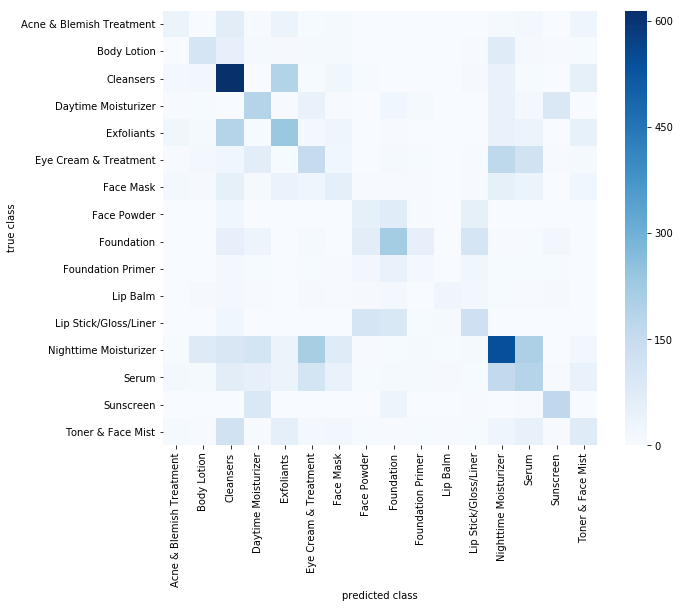

In [8]:
plt.figure(figsize=(10,8))
ax = sns.heatmap(train_confmat, cmap='Blues')
ax.set_aspect("equal")
plt.show()

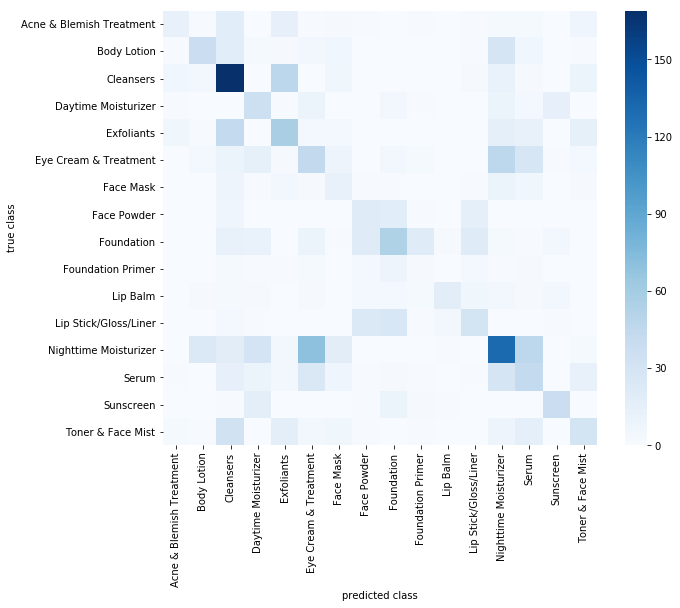

In [9]:
plt.figure(figsize=(10,8))
ax = sns.heatmap(test_confmat, cmap='Blues')
ax.set_aspect("equal")
plt.show()

#### More analysis for each category
* Accuracy
* Most Common miss-predictions
* Most predictive ingredients for each category

In [10]:
for i, (idx, row) in enumerate(test_confmat.iterrows()):
    accuracy = row[idx] / y_test[:,i].sum()
    print ("true class:", idx)
    print ("accuracy: %.3f"%accuracy)
    confused_class = row.sort_values(ascending=False).drop(idx).iloc[:3].index.values
    print ("top miss predictions:", confused_class, '\n')

true class: Acne & Blemish Treatment
accuracy: 0.333
top miss predictions: ['Cleansers' 'Exfoliants' 'Toner & Face Mist'] 

true class: Body Lotion
accuracy: 0.613
top miss predictions: ['Nighttime Moisturizer' 'Cleansers' 'Serum'] 

true class: Cleansers
accuracy: 0.899
top miss predictions: ['Exfoliants' 'Nighttime Moisturizer' 'Toner & Face Mist'] 

true class: Daytime Moisturizer
accuracy: 0.692
top miss predictions: ['Sunscreen' 'Nighttime Moisturizer' 'Eye Cream & Treatment'] 

true class: Exfoliants
accuracy: 0.576
top miss predictions: ['Cleansers' 'Nighttime Moisturizer' 'Toner & Face Mist'] 

true class: Eye Cream & Treatment
accuracy: 0.454
top miss predictions: ['Nighttime Moisturizer' 'Serum' 'Daytime Moisturizer'] 

true class: Face Mask
accuracy: 0.361
top miss predictions: ['Nighttime Moisturizer' 'Cleansers' 'Serum'] 

true class: Face Powder
accuracy: 0.870
top miss predictions: ['Foundation' 'Lip Stick/Gloss/Liner' 'Cleansers'] 

true class: Foundation
accuracy: 0.90

Make a prediction for each individual ingredient, for each category, find the top 10 ingredients that give highest probability.

In [11]:
n_ingredients = ingredient_count_df.shape[1]
X_ingredients = np.eye(n_ingredients,n_ingredients)
y_ingredients = model.predict_proba(X_ingredients)

most_relevant_ingredients = pd.DataFrame()
for i in range(len(mlb.classes_)):
    ind = np.argsort(y_ingredients[:,i])
    top10 = np.flipud(ingredient_count_df.columns.values[ind[-10:]])
    most_relevant_ingredients[mlb.classes_[i]] = top10
    
most_relevant_ingredients

,Acne & Blemish Treatment,Body Lotion,Cleansers,Daytime Moisturizer,Exfoliants,Eye Cream & Treatment,Face Mask,Face Powder,Foundation,Foundation Primer,Lip Balm,Lip Stick/Gloss/Liner,Nighttime Moisturizer,Serum,Sunscreen,Toner & Face Mist
0,advanced glycation endproduct (AGE),Larrea tridentata,sodium palm kernelate,vitamin B3,alpha hydroxy acid,hesperidin methyl chalcone,glycerol triacetate,isocetyl salicylate,titanium dioxide,gotu kola,flavor,red 27 lake,anthocyanin,durian,octocrylene,lye
1,benzoyl peroxide,erythrulose,sodium palmate,avobenzone,pectin,hesperidin,saccharomyces selenium ferment,English ivy extract,iron oxides,borate,aroma,yellow 6 lake,docosahexaenoic acid,styrene,phthalates,pellitory
2,fatty acid,black locust extract,sodium tallowate,padimate O,azelaic acid,oxidoreductase,rose hip,reducing agent,simethicone,vitamin B1,marshmallow,red 6 lake,spearmint oil,beta hydroxy acid,film-forming agent,mallow
3,Xi xin,neroli,tetrasodium etidronate,galbanum,trimellitic anhydride copolymer,Pseudopterogorgia elisabethae,bois oil,aluminum,astaxanthin extract,D&C,capsaicin,blue 1 lake,Helianthus oil,tetrahydromethoxycurcumin,homosalate,coneflower
4,sulfur,ylang ylang,lauric acid,eicosapentaenoic acid,BHA (beta hydroxy acid),tripeptide-32,Mentha viridis,capsicum oleoresin,Prunus americana,Arctium majus,lemon juice,terephthalylidene dicamphor sulfonic acid,lipid,Uva ursi extract,oxybenzone,nonoxynols
5,myristoyl tripeptide-31,stearalkonium chloride,potassium myristate,egg yolk,walnut shell powder,alpha bisabolol,Sambucus nigra,thymus hydrolysate,environmental damage,catalase,candelilla wax,jojoba,d-alpha-tocopherol,myristoyl hexapeptide-16,avobenzone,PPG-20
6,bakuchiol,Buxus chinensis,cocamidopropyl betaine,ecamsule,mandelic acid,lady's thistle (milk thistle) extract,silt,glyceryl ester,isopropyl titanium triisostearte,glyceryl ester,Ricinus communis,carmine,olive oil,marigold,diethylhexyl malate,soapwort
7,BHA (beta hydroxy acid),troxerutin,sodium cocoamphoacetate,jojoba butter,fatty acid,vitamin D,kaolin,tetrahydrodemethoxycurcumin,acetyl glyceryl ricinoleate,Astragalus sinicus,Illicium vernum,fir needle oil,olive fruit oil,locust bean,octisalate,burdock root
8,sebacic acid,anisaldehyde,sodium laureth sulfate,film-forming agent,mugwort extract,polyhydroxy acid,bentonite,fish cartilage extract,methicone,thymus hydrolysate,candelilla,China clay,gums,soy extract,eicosene copolymer,lemon
9,colloidal silver,hydroxyethyl acrylate,sodium cocoyl isethionate,Tanacetum parthenium,Citrus amara,verbena extract,montmorillonite,GLA,disteardimonium hectorite,GLA,capsicum oleoresin,gluten ingredients,nicotinic acid,Althaea rosea,citrate buffer,mixed fruit extracts


### Multinomial Naive Bayes for ingredient category count features

In [13]:
cols = [f_ for f_ in df.columns.values if f_.find('cat_count')>=0]
X_train = df_train[cols].fillna(0)
X_test = df_test[cols].fillna(0)

mNB = MultinomialNB()
model = OneVsRestClassifier(mNB)

# get oof predictions on training set
y_train_pred_mNB, y_train_pred_proba_mNB = oof_preds(X_train.values, y_train, model, fold)

# train on the whole training set and predict for test set
model.fit(X_train, y_train)
y_test_pred_mNB = model.predict(X_test)
y_test_pred_proba_mNB = model.predict_proba(X_test)

In [19]:
train_score = hamming_score(y_train, y_train_pred_mNB)
test_score = hamming_score(y_test, y_test_pred_mNB)
print("Hamming score: (train)%.4f, (test)%.4f" %(train_score, test_score))

Hamming score: (train)0.2704, (test)0.2770


### Final Training

Merge predictions of Bernoullie Naive Bayes and Multinomial Naive Bays with general ingredient features

In [14]:
cols = ['n_active_ingredient', 'is_alphabatical',
        'inactive_rating_count_0.0', 'inactive_rating_count_1.0',
        'inactive_rating_count_2.0', 'inactive_rating_count_3.0',
        'active_rating_count_0.0', 'active_rating_count_1.0',
        'active_rating_count_2.0', 'active_rating_count_3.0']

X_train = np.concatenate([df_train[cols].fillna(0).values, y_train_pred_bNB, y_train_pred_mNB], axis=1)
X_test  = np.concatenate([df_test[cols].fillna(0).values, y_test_pred_bNB, y_test_pred_mNB], axis=1)
X_train.shape, X_test.shape

((4496, 42), (1124, 42))

Use XGBClassifier as final model.

In [42]:
#clf = RandomForestClassifier(n_estimators=200, max_depth=7, class_weight='balanced')
clf = XGBClassifier(n_estimators=200, max_depth=7, class_weight='balanced', learning_rate=0.1)
model = OneVsRestClassifier(clf)
#y_train_pred, y_train_pred_proba = oof_preds(X_train, y_train, model, fold)

model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
y_test_pred_proba = model.predict_proba(X_test)

#### Evaluation

In [43]:
train_score = hamming_score(y_train, y_train_pred)
test_score = hamming_score(y_test, y_test_pred)
print("Hamming score: (train)%.4f, (test)%.4f" %(train_score, test_score))

train_confmat = multilable_confusion_matrix(y_train, y_train_pred, mlb.classes_)
test_confmat = multilable_confusion_matrix(y_test, y_test_pred, mlb.classes_)

Hamming score: (train)0.3521, (test)0.3961


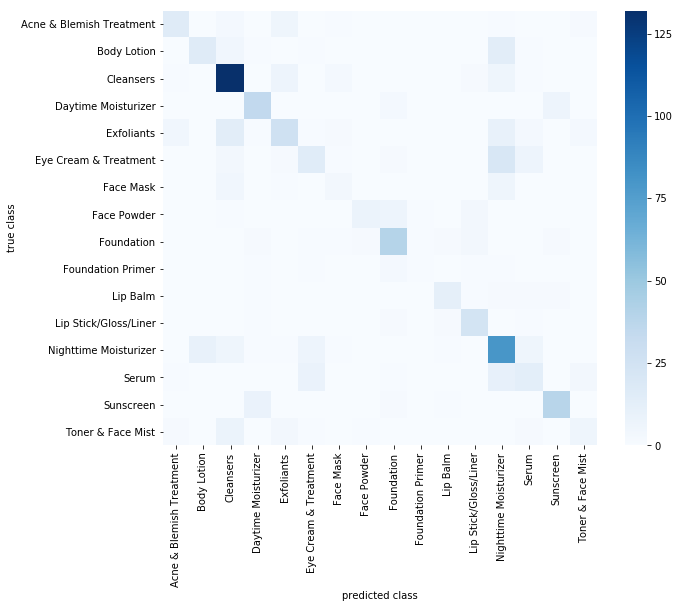

In [35]:
plt.figure(figsize=(10,8))
ax = sns.heatmap(test_confmat, cmap='Blues')
ax.set_aspect("equal")
plt.show()

In [36]:
for i, (idx, row) in enumerate(test_confmat.iterrows()):
    accuracy = row[idx] / y_test[:,i].sum()
    print ("true class:", idx)
    print ("accuracy: %.3f"%accuracy)
    confused_class = row.sort_values(ascending=False).drop(idx).iloc[:3].index.values
    print ("top miss predictions:", confused_class, '\n')

true class: Acne & Blemish Treatment
accuracy: 0.410
top miss predictions: ['Exfoliants' 'Cleansers' 'Toner & Face Mist'] 

true class: Body Lotion
accuracy: 0.258
top miss predictions: ['Nighttime Moisturizer' 'Cleansers' 'Serum'] 

true class: Cleansers
accuracy: 0.702
top miss predictions: ['Exfoliants' 'Nighttime Moisturizer' 'Face Mask'] 

true class: Daytime Moisturizer
accuracy: 0.673
top miss predictions: ['Sunscreen' 'Foundation' 'Toner & Face Mist'] 

true class: Exfoliants
accuracy: 0.273
top miss predictions: ['Cleansers' 'Nighttime Moisturizer' 'Acne & Blemish Treatment'] 

true class: Eye Cream & Treatment
accuracy: 0.155
top miss predictions: ['Nighttime Moisturizer' 'Serum' 'Cleansers'] 

true class: Face Mask
accuracy: 0.111
top miss predictions: ['Nighttime Moisturizer' 'Cleansers' 'Exfoliants'] 

true class: Face Powder
accuracy: 0.348
top miss predictions: ['Foundation' 'Lip Stick/Gloss/Liner' 'Foundation Primer'] 

true class: Foundation
accuracy: 0.667
top miss pr